<a href="https://colab.research.google.com/github/MaralAminpour/ML-BME-Course-UofA-Fall-2023/blob/main/Week-4-Regression-models/4.2-Linear-regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multivariate Linear Regression

In this notebook we will look at **Multivariate Linear Regression** which seeks to fit the model

$$y=w_0+w_1x_1+...+w_Dx_D$$

where $(x_1,...,x_D)^T$ is the *feature vector*, $\hat{y}$ is the *target value* and $(w_0,...,w_D)^T$ is the *weight vector* formed of parameters of the regression model that we seek to find.

We will first investigate how it is implemented in `sklearn`. Then we will look at measuring the performance of regression methods and investigate how the dimension of the feature vector influences the performance of the linear regression.

## Dataset

<img src="https://raw.githubusercontent.com/SirTurtle/ML-BME-UofA-imgs/main/Week-4-Regression-models/imgs/BrainVolumes.png" width = "500" style="float: right;">

The biomedical application that we will investigate in this notebook is prediction of gestational age (GA) from volumes of brain structures. The brain volumes were measured based on an analysis of MRI scans. The brain volumes come from the **Developing Human Connectome Project** (dHCP, www.developingconnectome.org). We will use three different feature vectors:

* **Whole brain volume - a single feature**
* **Volumes of main brain structures - six features:** cortical gray matter, cortical white matter, myelinated subcortical white matter, subcortical gray matter, cerebellum and brainstem.
* **Volumes of all dHCP brain structures - 86 features**

The segmentations were performed using dHCP processing pipeline (www.doi.org/10.1016/j.neuroimage.2018.01.054). The software is available for download here: www.github.com/MIRTK/DrawEM.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import requests
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score

## Multivariate Linear Regression in Scikit-learn

### Load the dataset

We will first explore the multivariate linear regression using the dataset with 6 brain volumes for prediction of GA at scan.

The code bellow loads the dataset, extract the feature matrix and the target vector, and scales the features using `StandardScaler`. This is implemented in the function `CreateFeaturesTargets`, which accepts a 'csv' file as an input and returns extracted feature matrix `X` that contains the volumes and target vector `y`with GA.

In [ ]:
# This code will download the required data files from GitHub
def download_data(source, dest):
    base_url = 'https://raw.githubusercontent.com/'
    owner = 'SirTurtle'
    repo = 'ML-BME-UofA-data'
    branch = 'main'
    url = '{}/{}/{}/{}/{}'.format(base_url, owner, repo, branch, source)
    r = requests.get(url)
    f = open(dest, 'wb')
    f.write(r.content)
    f.close()

# Create the temp directory, if it doesn't already exist
import os
if not os.path.exists('temp'):
   os.makedirs('temp')

download_data('Week-4-Regression-models/data/GA-brain-volumes-1-feature.csv', 'temp/GA-brain-volumes-1-feature.csv')
download_data('Week-4-Regression-models/data/GA-brain-volumes-6-features.csv', 'temp/GA-brain-volumes-6-features.csv')
download_data('Week-4-Regression-models/data/GA-brain-volumes-86-features.csv', 'temp/GA-brain-volumes-86-features.csv')

We will use the 6 features dataset for now.

In [ ]:
df = pd.read_csv('temp/GA-brain-volumes-6-features.csv', names=['GA', 'Structure 0', 'Struture 1', 'Structure 2', 'Structure 3', 'Structure 4', 'Structure 5'])

# Features are in columns one to end
X = df.values[1:, 1:]

# Scale features
X = StandardScaler().fit_transform(X)

# Labels are in the column zero
y = df.values[1:, 0]

print('Number of samples is', X.shape[0])
print('Number of features is', X.shape[1])

Number of samples is 163
Number of features is 6


### Data Dictionary

**GA**: Gestational Age (in weeks).

**Structure [0-5]**: Volume of brain structure [0-5].

### Visualise the dataset

First, we will do some EDA. Run the code below to visualise the correlation of individual features of this dataset with the GA.

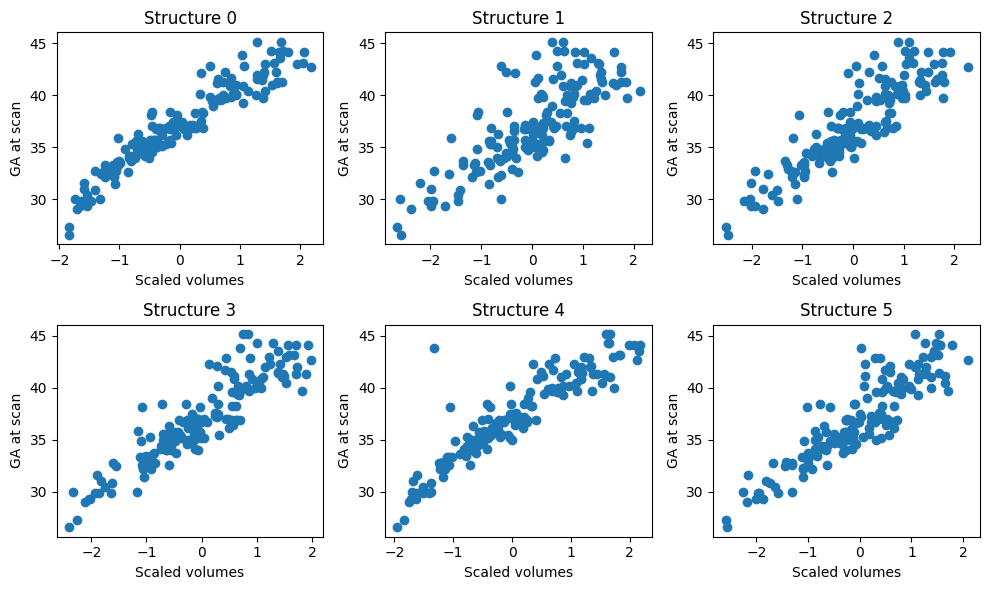

In [ ]:
plt.figure(figsize=(10,6))

for i in range(6):
        plt.subplot(2,3,i+1)
        plt.scatter(X[:,i], y)
        plt.xlabel('Scaled volumes')
        plt.ylabel('GA at scan')
        plt.title('Structure '+ str(i))

plt.tight_layout()

It is clear visually that all 6 volumes in our dataset are correlated with GA. Next, we will visualize the correlation matrix for all the features and the gestational age.

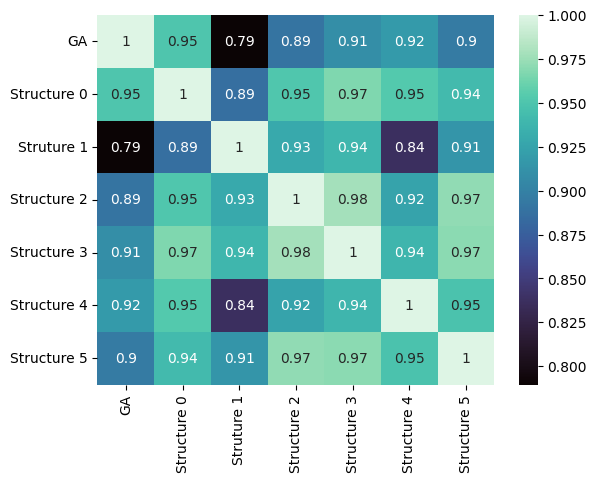

In [ ]:
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='mako')
plt.show()

### Fit model using normal equation

The code below fits the [`LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression) model to the data using the **normal equation**. The performance is evaluated using the **Root Mean Squared Error** (RMSE). This is done first on the whole dataset using function `mean_squared_error` and then using cross-validation implemented by a sklearn function [`cross_val_score`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score). Run the code.

In [ ]:
# Choose the linear regression model
lr_model = LinearRegression()

# Calculate RMSE on the whole set
lr_model.fit(X, y)

y_pred = lr_model.predict(X)

# Calculate and print the R2 and RMSE scores
r2 = r2_score(y, y_pred)
# We could alternately calculate the R2 score using the model's score method:
# lr_model.score(X, y)
print('R2: {:.2f}'.format(r2))
rmse = np.sqrt(mean_squared_error(y, y_pred))
print('RMSE: {:.2f} weeks'.format(rmse))

# Calculate scores using cross-validation
r2_scores = cross_val_score(LinearRegression(), X, y, scoring='neg_mean_squared_error', cv=5)
rmse_cv = np.sqrt(-np.mean(r2_scores))
print('RMSE_CV: {:.2f} weeks'.format(rmse_cv))

R2: 0.92
RMSE: 1.12 weeks
RMSE_CV: 1.28 weeks


**Question:** Notice the RMSE. In which units is it? We calculate RMSE on the whole dataset and using cross-validation. Which one is larger? We will later compare these errors to other regression methods.

**Answer:**

### Fit model using SGD
We will now fit the model multivariate linear regression model using **stochastic gradient descent** implemented in `SGDRegressor`.

**To do:**

In the previous cell you have seen how to calculate RMSE. Complete the functions

* `RMSE` to calculate RMSE on the whole dataset
* `RMSE_CV` to calculate cross-validated RMSE

Run the code and compare the error to the fit using normal equation, that we have perfored before.

In [ ]:
def RMSE(model,X,y):
    model.fit(X,y)
    y_pred = model.predict(X)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    print('RMSE: {} weeks'.format(round(rmse,2)))
    return rmse

def RMSE_CV(model,X,y):
    scores = cross_val_score(model,X,y, scoring='neg_mean_squared_error',cv=5)
    rmse_cv = np.sqrt(-np.mean(scores))
    print('RMSE_CV: {} weeks'.format(round(rmse_cv,2)))
    return rmse_cv

from sklearn.linear_model import SGDRegressor

model = SGDRegressor(loss="squared_error", penalty=None)
rmse = RMSE(model,X,y)
rmse_cv = RMSE_CV(model,X,y)

RMSE: 1.18 weeks
RMSE_CV: 1.32 weeks


## Exercise 1: Compare performance of linear regression models with different numbers of features

In this exercise we will compare performance of multivariate linear regression models with different numbers of features to predidict age of a baby.

First we will now load the three datasets (1-feature, 6-feature and 86-feature) and print out number of features. Run the code.

In [ ]:
def CreateFeaturesTargets(filename):

    df = pd.read_csv(filename,header=None)

    # convert from 'DataFrame' to numpy array
    data = df.values

    # Features are in columns one to end
    X = data[:,1:]

    # Scale features
    X = StandardScaler().fit_transform(X)

    # Labels are in the column zero
    y = data[:,0]

    # return Features and Labels
    return X, y

In [ ]:
# Load the datasets. Target values y are the same for all datasets
X1,y = CreateFeaturesTargets('temp/GA-brain-volumes-1-feature.csv')
print('Number of features in X1 is', X1.shape[1])

X6,y = CreateFeaturesTargets('temp/GA-brain-volumes-6-features.csv')
print('Number of features in X6 is', X6.shape[1])

X86,y = CreateFeaturesTargets('temp/GA-brain-volumes-86-features.csv')
print('Number of features in X86 is', X86.shape[1])

Number of features in X1 is 1
Number of features in X6 is 6
Number of features in X86 is 86


In the next step we will create a linear regression model and calculate RMSE on the whole set. Use the function `RMSE` that we have created previously. Fill in the code below and run it.

In [ ]:
# Select the model
model = None

# Single feature
print('Single feature:')
#rmse1 = None

# 6 features
print('Six features:')
# rmse6 = None

# 86 features
print('86 features:')
# rmse86 = None

Single feature:
Six features:
86 features:


**Question:** What happens with RMSE on the whole set as we increase the number of features? Can you interpret this behaviour?

**Answer:**

Now let's calculate the cross-validated RMSE for the three different feature matrices. You can use function `RMSE_CV` that we created before to calculate and print out the scores.

In [ ]:
# Single feature
print('Single feature:')
# rmse_cv1 = None

# 6 features
print('Six features:')
# rmse_cv6 = None

# 86 features
print('86 features:')
# rmse_cv86 = None

Single feature:
Six features:
86 features:


**Question:** Which model performs the best? Which model is overfitted?

__Answer:__